In [1]:
import torch
cuda = torch.cuda.is_available()
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append("../../semi-supervised")
from models import ProdLDADeepGenerativeModel

In [4]:
y_dim = 2
z_dim = 100
h_dim = [100, 100]

num_topics = y_dim
a = 1.0
prior_mean = np.log(a) - np.mean(np.log(a))
prior_var = (((1.0 / a) * (1 - (2.0 / num_topics))) + (1.0 / (num_topics * num_topics)) * np.sum((1.0 / a)))

In [5]:
def initialize_model(in_dim, y_dim, z_dim, h_dim, prior_mean, prior_var):
    model = ProdLDADeepGenerativeModel([in_dim, y_dim, z_dim, h_dim], prior_mean, prior_var)
    
    return model

In [6]:
from inference import SVI, ImportanceWeightedSampler
from itertools import cycle
from torch.autograd import Variable

def train_semi_supervised(model, labelled, unlabelled, validation, cuda, epochs=4):
    # You can use importance weighted samples [Burda, 2015] to get a better estimate
    # on the log-likelihood.
    sampler = ImportanceWeightedSampler(mc=1, iw=1)

    def binary_cross_entropy(r, x):
        return -torch.sum(x * torch.log(r + 1e-8) + (1 - x) * torch.log(1 - r + 1e-8), dim=-1)

    if cuda:
        model = model.cuda()
    elbo = SVI(model, likelihood=binary_cross_entropy, sampler=sampler)

    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, betas=(0.9, 0.999))


    if cuda: 
        model = model.cuda()

    alpha = 1.0 * len(unlabelled) / len(labelled)

    for epoch in range(epochs):
        model.train()
        total_loss, accuracy = (0, 0)
        for (x, y), (u, _) in zip(cycle(labelled), unlabelled):
            #x, y, u = torch.from_numpy(x).float(), torch.from_numpy(y).float(), torch.from_numpy(u).float()
            # Wrap in variables
            x, y, u = Variable(x), Variable(y), Variable(u)

            if cuda:
                # They need to be on the same device and be synchronized.
                x, y = x.cuda(device=1), y.cuda(device=1)
                u = u.cuda(device=1)

            # print(x.sum())
            L = -elbo(x, y)
            U = -elbo(u)

            # Add auxiliary classification loss q(y|x)
            logits = model.classify(x)

            # Regular cross entropy
            classication_loss = torch.sum(y * torch.log(logits + 1e-8), dim=1).mean()

            J_alpha = L - alpha * classication_loss + U

            J_alpha.backward()
            optimizer.step()
            optimizer.zero_grad()

            total_loss += J_alpha.data.item()
            accuracy += torch.mean((torch.max(logits, 1)[1].data == torch.max(y, 1)[1].data).float())

        if epoch % 1 == 0:
            model.eval()
            m = len(unlabelled)
            print("Epoch: {}".format(epoch))
            print("[Train]\t\t J_a: {:.2f}, accuracy: {:.2f}".format(total_loss / m, accuracy / m))

            total_loss, accuracy = (0, 0)
            for x, y in validation:
                x, y = Variable(x), Variable(y)

                if cuda:
                    x, y = x.cuda(device=1), y.cuda(device=1)

                L = -elbo(x, y)
                U = -elbo(x)

                logits = model.classify(x)
                classication_loss = -torch.sum(y * torch.log(logits + 1e-8), dim=1).mean()

                J_alpha = L + alpha * classication_loss + U

                total_loss += J_alpha.data.item()

                _, pred_idx = torch.max(logits, 1)
                _, lab_idx = torch.max(y, 1)
                accuracy += torch.mean((torch.max(logits, 1)[1].data == torch.max(y, 1)[1].data).float())

            m = len(validation)
            print("[Validation]\t J_a: {:.2f}, accuracy: {:.2f}".format(total_loss / m, accuracy / m))
            
    return total_loss / m, accuracy / m

# Generate MC samples

In [7]:
def mc_samples(num_mc_samples, model, x_batch):
    model.train()
    mc_samples_ = [model.classify(x_batch) for _ in range(num_mc_samples)]
    return torch.stack(mc_samples_)

In [8]:
def bald_acq(mc_samples):
    #expected_entropy = -(mc_samples * (mc_samples + 1e-10).log()).sum(dim=-1).mean(dim=0)  # [batch size]
    expected_entropy = -np.mean(np.sum(mc_samples * np.log(mc_samples + 1e-10), axis=-1), axis=0)
    #expected_p = mc_samples.mean(dim=0)
    expected_p = np.mean(mc_samples, axis=0)
    #entropy_expected_p = - (expected_p * (expected_p + 1e-10).log()).sum(dim=-1)  # [batch size]
    entropy_expected_p = - np.sum(expected_p * np.log(expected_p + 1e-10), axis=-1)

    BALD_acq = entropy_expected_p - expected_entropy
    
    return BALD_acq

In [9]:
def query_new_data(num_data, num_mc_samples, model, unlabelled_data):
    unlabelled_data = torch.from_numpy(unlabelled_data).float()
    if cuda:
        unlabelled_data = unlabelled_data.cuda()
    mc_samples_ = mc_samples(num_mc_samples, model, unlabelled_data).cpu().detach().numpy()
    bald_acq_ = bald_acq(mc_samples_)
    #sorted_, indices = bald_acq_.sort()
    indices = bald_acq_.argsort()
    return indices[::-1][:num_data]

# Data

In [10]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/atakanguney94/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [11]:
from nltk.tokenize import word_tokenize
import os


X_ = []
y_ = []

pos_path = "./data/aclImdb/train/pos/"
poses = os.listdir(pos_path)[:]
pos_path + poses[0]

print("Reading positives...")
counter = 1
for f in poses:
    if counter%2500 == 0:
        print(counter,"/", len(poses))
    counter += 1
    
    with open(pos_path + f) as file:
        lines = file.readlines()
        lines = ''.join(lines)

        #words = word_tokenize(lines)
        X_.append(lines)
        y_.append(1)
        

neg_path = "./data/aclImdb/train/neg/"
negs = os.listdir(neg_path)[:]

print("Reading negatives...")
counter = 1
for f in negs:
    if counter%2500 == 0:
        print(counter, "/", len(negs))
    counter += 1
    
    with open(neg_path + f) as file:
        lines = file.readlines()
        lines = ''.join(lines)

        #words = word_tokenize(lines)
        X_.append(lines)
        y_.append(0)

Reading positives...
2500 / 12500
5000 / 12500
7500 / 12500
10000 / 12500
12500 / 12500
Reading negatives...
2500 / 12500
5000 / 12500
7500 / 12500
10000 / 12500
12500 / 12500


In [12]:
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [13]:
tf = CountVectorizer(stop_words="english", max_features=10000)

In [14]:
docs = tf.fit_transform(X_)

In [15]:
x_dim = len(tf.vocabulary_)

In [16]:
docs = docs.todense()

In [17]:
ohe = OneHotEncoder()
labels = ohe.fit_transform(np.expand_dims(y_, -1))

/home/atakanguney94/.virtualenvs/ML/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [18]:
labels = labels.todense()

In [19]:
X_train, X_valid, y_train, y_valid = train_test_split(docs, labels, test_size=0.20)

In [20]:
y_train.shape

(20000, 2)

In [21]:
x_labelled, x_unlabelled, y_labelled, y_unlabelled = train_test_split(X_train, y_train, train_size=0.02)

/home/atakanguney94/.virtualenvs/ML/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [22]:
x_labelled.shape, x_unlabelled.shape, y_labelled.shape, y_unlabelled.shape

((400, 10000), (19600, 10000), (400, 2), (19600, 2))

In [23]:
def create_batch(data, batch_size):
    x, y = data
    batch_idx = np.random.choice(x.shape[0], batch_size, replace=False)

    return torch.from_numpy(x[batch_idx]).float(), torch.from_numpy(y[batch_idx]).float()

In [24]:
def create_data_sets(labelled, unlabelled, batch_size):
    num_labelled = labelled[0].shape[0]
    num_unlabelled = unlabelled[0].shape[0]

    train_labelled = [create_batch(labelled, batch_size) for _ in range(num_labelled // batch_size)]
    train_unlabelled = [create_batch(unlabelled, batch_size) for _ in range(num_unlabelled // batch_size)]
    
    return train_labelled, train_unlabelled

In [25]:
def create_validation_set(validation, batch_size):
    num_validation = validation[0].shape[0]
    
    validation = [create_batch(validation, batch_size) for _ in range(num_validation // batch_size)]
    
    return validation

In [26]:
labelled, unlabelled = (x_labelled, y_labelled), (x_unlabelled, y_unlabelled)

In [27]:
train_labelled, train_unlabelled = create_data_sets(labelled, unlabelled, 50)

In [28]:
validation = create_validation_set((X_valid, y_valid), 50)

# Active Learning

In [29]:
NUM_MC_SAMPLES = 10
NUM_QUERY = 200

In [30]:
def rearange_datasets(labelled, unlabelled, new_data):
    labelled_x, labelled_y = labelled
    unlabelled_x, unlabelled_y = unlabelled
    
    new_data_x, new_data_y = unlabelled_x[new_data], unlabelled_y[new_data]
    
    new_labelled_x = np.append(labelled_x, new_data_x, axis=0)
    new_labelled_y = np.append(labelled_y, new_data_y, axis=0)
    
    new_unlabelled_x = np.delete(unlabelled_x, new_data, axis=0)
    new_unlabelled_y = np.delete(unlabelled_y, new_data, axis=0)
    
    return (new_labelled_x, new_labelled_y), (new_unlabelled_x, new_unlabelled_y)

In [31]:
torch.cuda.set_device(1)

In [32]:
torch.cuda.current_device()

1

In [33]:
errors = []
batch_size=50
for i in range(50):
    model = initialize_model(x_dim, y_dim, z_dim, h_dim, prior_mean, prior_var)
    train_labelled, train_unlabelled = create_data_sets(labelled, unlabelled, batch_size)
    
    print(labelled[0].shape[0], unlabelled[0].shape[0])
    error, acc = train_semi_supervised(model, train_labelled, train_unlabelled, validation, cuda, epochs=10)
    errors.append((labelled[0].shape[0], unlabelled[0].shape[0], error, acc))
    
    new_data = query_new_data(NUM_QUERY, NUM_MC_SAMPLES, model, unlabelled[0])
    labelled, unlabelled = rearange_datasets(labelled, unlabelled, new_data)
    torch.cuda.empty_cache()

400 19600


../../semi-supervised/models/prodlda.py:57: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.activation(x)
../../semi-supervised/models/prodlda.py:65: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.output_activation(x)


Epoch: 0
[Train]		 J_a: 2136.95, accuracy: 0.99
[Validation]	 J_a: 2230.68, accuracy: 0.50
Epoch: 1
[Train]		 J_a: 1979.29, accuracy: 1.00
[Validation]	 J_a: 2248.51, accuracy: 0.49
Epoch: 2
[Train]		 J_a: 1885.29, accuracy: 1.00
[Validation]	 J_a: 2248.34, accuracy: 0.49
Epoch: 3
[Train]		 J_a: 1815.71, accuracy: 1.00
[Validation]	 J_a: 2214.78, accuracy: 0.49
Epoch: 4
[Train]		 J_a: 1768.83, accuracy: 1.00
[Validation]	 J_a: 2182.41, accuracy: 0.49
Epoch: 5
[Train]		 J_a: 1730.24, accuracy: 1.00
[Validation]	 J_a: 2170.96, accuracy: 0.49
Epoch: 6
[Train]		 J_a: 1695.44, accuracy: 1.00
[Validation]	 J_a: 2160.17, accuracy: 0.49
Epoch: 7
[Train]		 J_a: 1661.95, accuracy: 1.00
[Validation]	 J_a: 2150.57, accuracy: 0.49
Epoch: 8
[Train]		 J_a: 1627.54, accuracy: 1.00
[Validation]	 J_a: 2136.82, accuracy: 0.49
Epoch: 9
[Train]		 J_a: 1596.98, accuracy: 1.00
[Validation]	 J_a: 2148.26, accuracy: 0.49
600 19400
Epoch: 0
[Train]		 J_a: 1960.14, accuracy: 0.99
[Validation]	 J_a: 2179.28, accu

[Validation]	 J_a: 25107.46, accuracy: 0.52
2200 17800
Epoch: 0
[Train]		 J_a: 1780.99, accuracy: 0.88
[Validation]	 J_a: 2011.33, accuracy: 0.52
Epoch: 1
[Train]		 J_a: 1621.43, accuracy: 0.98
[Validation]	 J_a: 5189.12, accuracy: 0.53
Epoch: 2
[Train]		 J_a: 1567.51, accuracy: 1.00
[Validation]	 J_a: 2468.37, accuracy: 0.52
Epoch: 3
[Train]		 J_a: 1532.18, accuracy: 1.00
[Validation]	 J_a: 2547.90, accuracy: 0.51
Epoch: 4
[Train]		 J_a: 1503.48, accuracy: 1.00
[Validation]	 J_a: 3190.69, accuracy: 0.51
Epoch: 5
[Train]		 J_a: 1476.20, accuracy: 1.00
[Validation]	 J_a: 5915.02, accuracy: 0.51
Epoch: 6
[Train]		 J_a: 1452.50, accuracy: 1.00
[Validation]	 J_a: 48379.52, accuracy: 0.51
Epoch: 7
[Train]		 J_a: 1430.27, accuracy: 1.00
[Validation]	 J_a: 15547.22, accuracy: 0.51
Epoch: 8
[Train]		 J_a: 1412.80, accuracy: 1.00
[Validation]	 J_a: 52803.84, accuracy: 0.51
Epoch: 9
[Train]		 J_a: 1399.35, accuracy: 1.00
[Validation]	 J_a: 56445.42, accuracy: 0.51
2400 17600
Epoch: 0
[Train]		 J

[Validation]	 J_a: 4103.63, accuracy: 0.52
Epoch: 9
[Train]		 J_a: 1422.53, accuracy: 1.00
[Validation]	 J_a: 7335.88, accuracy: 0.52
4000 16000
Epoch: 0
[Train]		 J_a: 1843.97, accuracy: 0.56
[Validation]	 J_a: 2016.98, accuracy: 0.51
Epoch: 1
[Train]		 J_a: 1717.62, accuracy: 0.78
[Validation]	 J_a: 1954.53, accuracy: 0.51
Epoch: 2
[Train]		 J_a: 1651.01, accuracy: 0.93
[Validation]	 J_a: 1914.37, accuracy: 0.52
Epoch: 3
[Train]		 J_a: 1594.52, accuracy: 0.98
[Validation]	 J_a: 1880.53, accuracy: 0.52
Epoch: 4
[Train]		 J_a: 1556.53, accuracy: 1.00
[Validation]	 J_a: 1840.62, accuracy: 0.53
Epoch: 5
[Train]		 J_a: 1526.26, accuracy: 1.00
[Validation]	 J_a: 1822.33, accuracy: 0.53
Epoch: 6
[Train]		 J_a: 1501.52, accuracy: 1.00
[Validation]	 J_a: 1802.67, accuracy: 0.53
Epoch: 7
[Train]		 J_a: 1481.46, accuracy: 1.00
[Validation]	 J_a: 1791.27, accuracy: 0.53
Epoch: 8
[Train]		 J_a: 1463.92, accuracy: 1.00
[Validation]	 J_a: 1765.91, accuracy: 0.53
Epoch: 9
[Train]		 J_a: 1448.93, acc

[Validation]	 J_a: 1761.75, accuracy: 0.55
Epoch: 8
[Train]		 J_a: 1521.78, accuracy: 1.00
[Validation]	 J_a: 1747.78, accuracy: 0.55
Epoch: 9
[Train]		 J_a: 1505.42, accuracy: 1.00
[Validation]	 J_a: 1730.58, accuracy: 0.56
5800 14200
Epoch: 0
[Train]		 J_a: 1922.16, accuracy: 0.51
[Validation]	 J_a: 2008.81, accuracy: 0.51
Epoch: 1
[Train]		 J_a: 1782.08, accuracy: 0.62
[Validation]	 J_a: 1932.44, accuracy: 0.51
Epoch: 2
[Train]		 J_a: 1709.05, accuracy: 0.80
[Validation]	 J_a: 1899.88, accuracy: 0.53
Epoch: 3
[Train]		 J_a: 1672.98, accuracy: 0.91
[Validation]	 J_a: 1872.59, accuracy: 0.54
Epoch: 4
[Train]		 J_a: 1645.63, accuracy: 0.96
[Validation]	 J_a: 1850.38, accuracy: 0.55
Epoch: 5
[Train]		 J_a: 1622.43, accuracy: 0.98
[Validation]	 J_a: 1828.12, accuracy: 0.55
Epoch: 6
[Train]		 J_a: 1600.98, accuracy: 0.99
[Validation]	 J_a: 1800.99, accuracy: 0.56
Epoch: 7
[Train]		 J_a: 1580.91, accuracy: 1.00
[Validation]	 J_a: 1779.20, accuracy: 0.56
Epoch: 8
[Train]		 J_a: 1561.88, acc

[Validation]	 J_a: 1814.21, accuracy: 0.55
Epoch: 7
[Train]		 J_a: 1666.16, accuracy: 0.98
[Validation]	 J_a: 1790.63, accuracy: 0.56
Epoch: 8
[Train]		 J_a: 1646.70, accuracy: 0.99
[Validation]	 J_a: 1774.47, accuracy: 0.56
Epoch: 9
[Train]		 J_a: 1629.60, accuracy: 0.99
[Validation]	 J_a: 1759.26, accuracy: 0.56
7600 12400
Epoch: 0
[Train]		 J_a: 2016.11, accuracy: 0.50
[Validation]	 J_a: 2026.39, accuracy: 0.49
Epoch: 1
[Train]		 J_a: 1885.98, accuracy: 0.51
[Validation]	 J_a: 1962.86, accuracy: 0.50
Epoch: 2
[Train]		 J_a: 1835.19, accuracy: 0.64
[Validation]	 J_a: 1923.94, accuracy: 0.50
Epoch: 3
[Train]		 J_a: 1789.04, accuracy: 0.78
[Validation]	 J_a: 1891.26, accuracy: 0.51
Epoch: 4
[Train]		 J_a: 1743.18, accuracy: 0.88
[Validation]	 J_a: 1851.70, accuracy: 0.52
Epoch: 5
[Train]		 J_a: 1705.13, accuracy: 0.94
[Validation]	 J_a: 1828.11, accuracy: 0.53
Epoch: 6
[Train]		 J_a: 1674.35, accuracy: 0.97
[Validation]	 J_a: 1806.22, accuracy: 0.54
Epoch: 7
[Train]		 J_a: 1647.76, acc

[Validation]	 J_a: 1825.32, accuracy: 0.55
Epoch: 6
[Train]		 J_a: 1742.62, accuracy: 0.91
[Validation]	 J_a: 1809.27, accuracy: 0.56
Epoch: 7
[Train]		 J_a: 1718.07, accuracy: 0.94
[Validation]	 J_a: 1783.15, accuracy: 0.56
Epoch: 8
[Train]		 J_a: 1696.39, accuracy: 0.96
[Validation]	 J_a: 1772.02, accuracy: 0.57
Epoch: 9
[Train]		 J_a: 1677.45, accuracy: 0.98
[Validation]	 J_a: 1760.77, accuracy: 0.58
9400 10600
Epoch: 0
[Train]		 J_a: 2089.67, accuracy: 0.49
[Validation]	 J_a: 2016.45, accuracy: 0.51
Epoch: 1
[Train]		 J_a: 1969.31, accuracy: 0.49
[Validation]	 J_a: 1970.27, accuracy: 0.51
Epoch: 2
[Train]		 J_a: 1924.09, accuracy: 0.54
[Validation]	 J_a: 1932.30, accuracy: 0.51
Epoch: 3
[Train]		 J_a: 1883.17, accuracy: 0.64
[Validation]	 J_a: 1884.98, accuracy: 0.52
Epoch: 4
[Train]		 J_a: 1841.52, accuracy: 0.75
[Validation]	 J_a: 1864.78, accuracy: 0.54
Epoch: 5
[Train]		 J_a: 1801.92, accuracy: 0.84
[Validation]	 J_a: 1828.42, accuracy: 0.55
Epoch: 6
[Train]		 J_a: 1765.46, acc

In [ ]:
torch.cuda.empty_cache()

In [34]:
len(errors)

50

In [35]:
num_labelled = []
num_unlabelled = []
cost = []
acc = []

for n_l, n_u, c, a in errors:
    num_labelled.append(n_l)
    num_unlabelled.append(n_u)
    cost.append(c)
    acc.append(a)

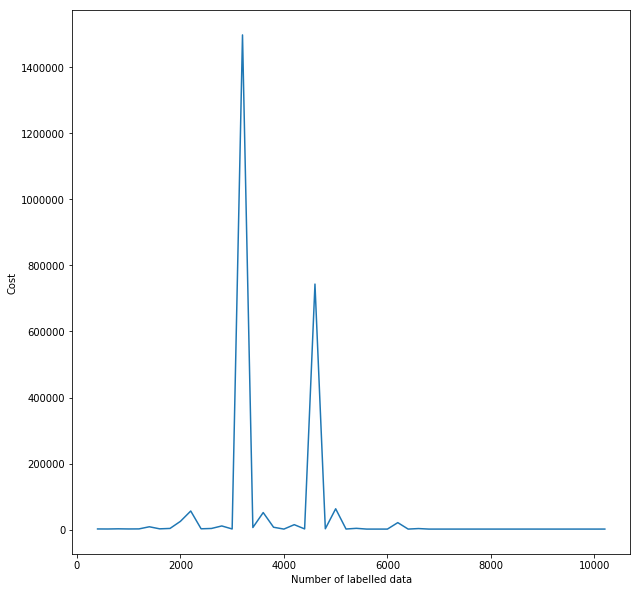

In [41]:
plt.figure(figsize=(10, 10))
plt.plot(num_labelled, cost)
plt.xlabel("Number of labelled data")
plt.ylabel("Cost")
plt.savefig("n_labelled_vs_cost.png")

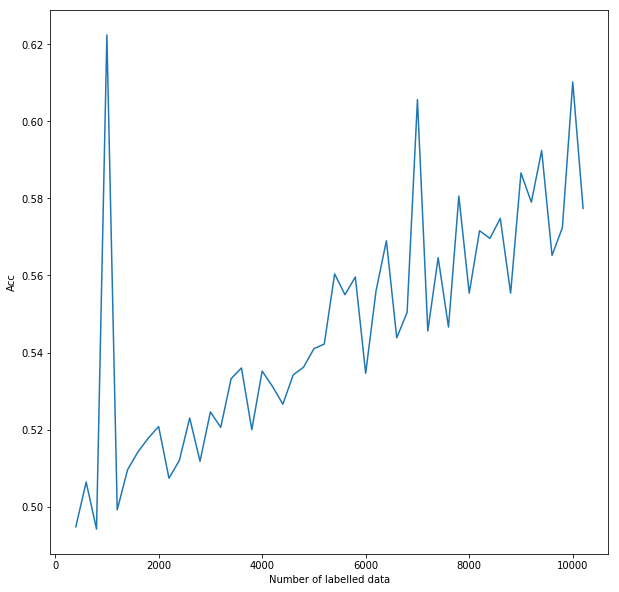

In [42]:
plt.figure(figsize=(10, 10))
plt.plot(num_labelled, acc)
plt.xlabel("Number of labelled data")
plt.ylabel("Acc")
plt.savefig("n_labelled_vs_acc.png")

In [43]:
import pickle

In [ ]:
with open("IMDB-data-res")